This tutorial can be run under `examples` directory of `qsofitmore`. For basics of `PyQSOFit`, see https://github.com/legolason/PyQSOFit/blob/master/example/example.ipynb

### 2.2 Import `QSOFitNew` class from `qsofitmore` 

In [1]:
from qsofitmore import QSOFitNew
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

The output path (`path`) should contain a line list file (`qsopar.fits` generated in `1-make_parlist.ipynb`). The output files (including fits table and plots) are stored in `path`. 

In [2]:
path = "./output/"

#### a) From numpy-array like data 

We can read an example spectrum in csv format using `pandas`, and load the data to `QSOFitNew` manually. The data should contain wavelength (in Å), flux and flux error. In this example, the flux and error are in the unit of erg/s/cm^2/Å. Because the code assumes the flux is in unit of 10^-17 erg/s/cm^2/Å, we need to multiply the flux and error by 1e17. The redshift, RA, DEC, and name of the quasar are also required. The `is_sdss` parameter is set to `False` because this spectrum is not from SDSS. The object `J001554.18+560257.5` is from the suvey for quasars behind the Galactic plane ([Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJS..261...32F/abstract)), and was observed with the 2.4m Lijiang Telescope (LJT) in China. The `path` parameter is set to the output path where the fits file and plots will be saved.


In [3]:
df = pd.read_csv("./data/spec_J001554.18+560257.5_LJT.csv")
q = QSOFitNew(lam=df.lam, flux=df.flux*1e17, err=df.err*1e17, 
              z=0.1684, ra=3.97576206, dec=56.04931383,
              name='J001554.18+560257.5', is_sdss=False, path=path)

#### b) From IRAF multispec

If you have a spectrum generated by `IRAF`/`PyRAF`, in which case the 4 bands of the fits file are:  
BANDID1 = 'spectrum - background fit, weights variance, clean no'               
BANDID2 = 'raw - background fit, weights none, clean no'                        
BANDID3 = 'background - background fit'                                         
BANDID4 = 'sigma - background fit, weights variance, clean no'  
The first and fourth bands are flux and flux error, respectively, in unit $\rm erg\;s^{-1}\;cm^{-2}\,\AA^{-1}$
You can simply load the data with the classmethod `QSOFitNew.fromiraf`, which does the unit conversion automatically.

In [4]:
q = QSOFitNew.fromiraf("./data/spec_J001554.18+560257.5_LJT.fits",
                       redshift=0.1684,telescope='LJT',path=path)

### 2.4 Fit the spectrum 

#### Choose a dust map (default: sfd map)

In [5]:
q.setmapname("sfd")

The code supports three Galactic‐extinction maps:

 - `"sfd"`: Schlegel, Finkbeiner & Davis (1998) dust map  (this is the default)  
 - `"planck"` or `"planck16"`: Planck GNILC dust map (Planck Collaboration 2016)  
 - `"planck14"`: Planck dust map (Planck Collaboration 2014)

```python
# use the default SFD98 map
q.setmapname("sfd")

# use the default Planck GNILC (2016) map
q.setmapname("planck")     # same as "planck16"

# explicitly use the older Planck (2014) map
q.setmapname("planck14")
```

 If you select `"planck"`/`"planck16"` or `"planck14"`, make sure you have:
 
 1. Installed and configured `dustmaps`  
 2. Downloaded the Planck dust maps via:
    ```python
    from dustmaps.config import config
    config['data_dir'] = '/path/to/store/maps'
    import dustmaps.planck
    dustmaps.planck.fetch()
    ```

#### Apply `q.Fit()`  

Derived quantities of narrow and broad lines, including FWHM, sigma, EW, and integrated flux (area), are calculated during the fitting process and stored in the output fits file. By specifying `MC = True` when calling `q.Fit()`, the code will also calculate the uncertainties of these quantities using Monte Carlo simulations. The uncertainties are stored in the output fits file as well.

##### A simple example


The dust map is sfd.
Get negtive host galaxy flux larger than 100 pixels, decomposition is not applied!
['NeV3426', 'OII3728', 'Hg_na', 'Hb_na', 'OIII4959', 'OIII5007', 'OIII4959w', 'OIII5007w', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732']


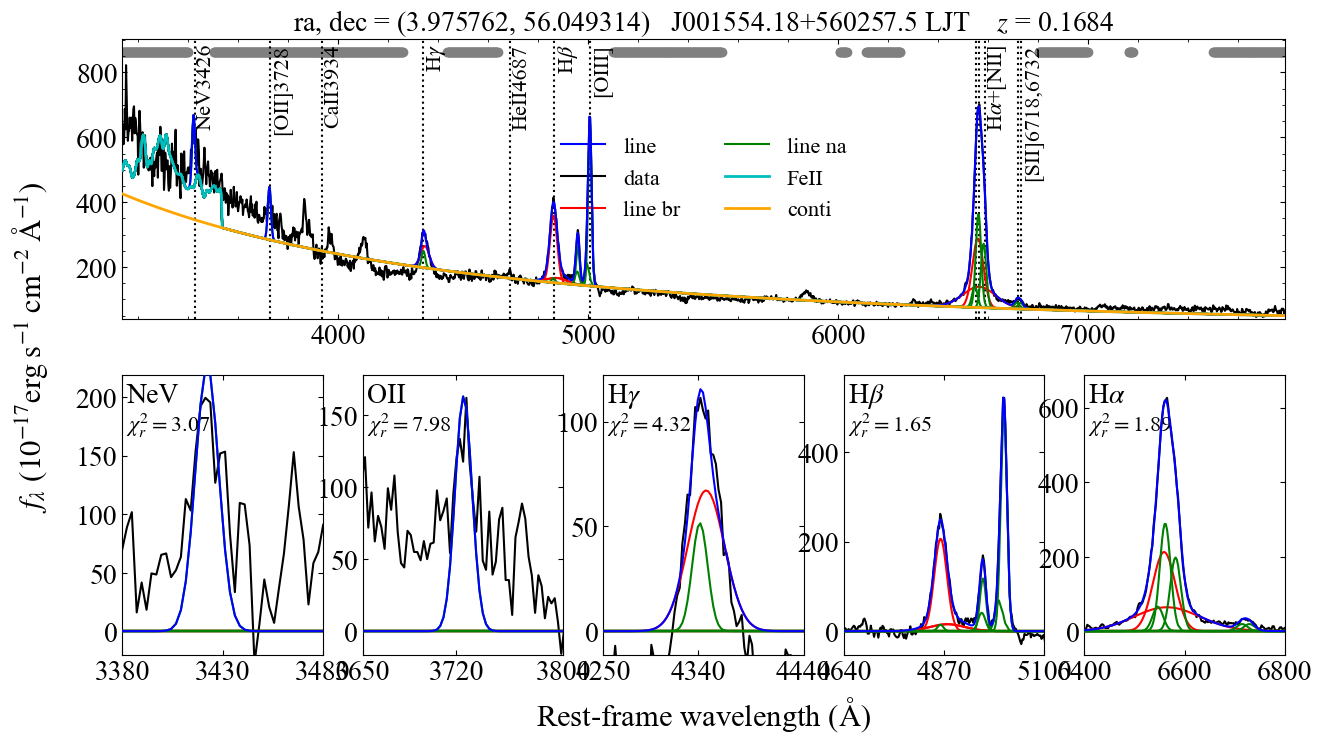

In [6]:
q.Fit(name = None,
      deredden          = True,
      wave_range        = None,
      wave_mask         = None,
      decomposition_host= True,
      Mi                = None,
      npca_gal          = 5,
      npca_qso          = 20,
      include_iron      = True,                   # enable FeII fitting
      iron_temp_name    = "BG92-VW01",            # options: "BG92-VW01", "V09", "G12"
      poly              = False,
      BC                = False,
      MC                = False,
      n_trails          = 20,
      linefit           = True,
      tie_lambda        = True,
      tie_width         = True,
      tie_flux_1        = True,
      tie_flux_2        = True,
      save_result       = True,
      plot_fig          = True,
      save_fig          = True,
      plot_line_name    = True,
      plot_legend       = True,
      save_fits_name    = None)

**Note**:

The fit above is not a good one, because it fails to account for the Balmer continuum and high-order Balmer lines. Below is a more advanced example that includes this feature, and uses a broken power-law model for the continuum.

##### A more advanced example

- Use Planck 2016 dust map
- Add Balmer continuum and high-order Balmer lines
- Use Verner et al. (2009) Fe II template
- Use broken power-law model


The dust map is planck.
Get negtive host galaxy flux larger than 100 pixels, decomposition is not applied!
N_e for Balmer line series not set.
Setting N_e = 1E09. (q.set_log10_electron_density(9))
['w4434_w4684']
['NeV3426', 'OII3728', 'Hg_na', 'Hb_na', 'OIII4959', 'OIII5007', 'OIII4959w', 'OIII5007w', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732']


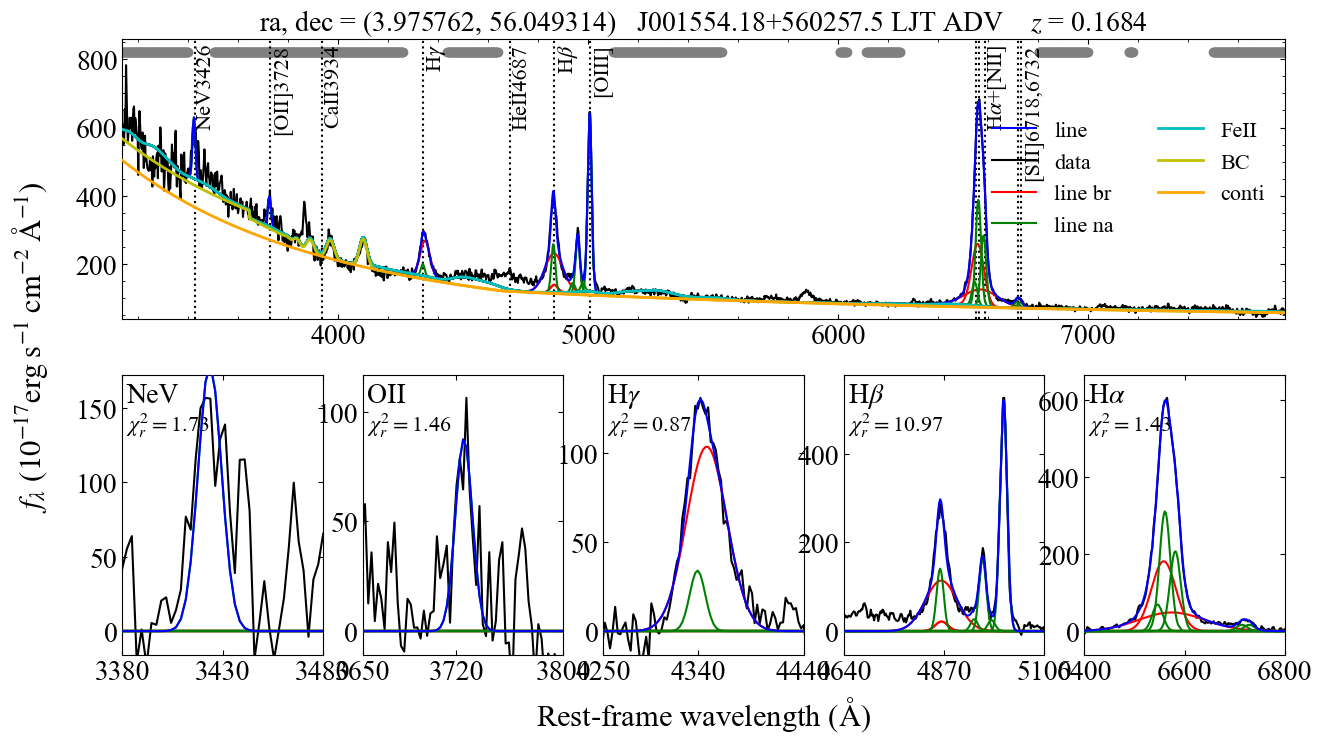

In [7]:
q = QSOFitNew.fromiraf("/Users/yuming/tools/qsofitmore/qsofitmore/examples/data/spec_J001554.18+560257.5_LJT.fits",
                       redshift=0.1684,telescope='LJT',path=path)
q.setmapname("planck")
q.Fit(name              = 'J001554.18+560257.5_LJT_ADV',
      deredden          = True,
      wave_range        = None,
      wave_mask         = None,
      Fe_flux_range     = [4434, 4684] , # Wavelength range of FeII flux saved to the output file
      decomposition_host= True,
      Mi                = None,
      npca_gal          = 5,
      npca_qso          = 20,
      include_iron      = True,          # enable FeII fitting
      iron_temp_name    = "V09",         # options: "BG92-VW01", "V09", "G12"
      poly              = False,
      broken_pl         = True,          # enable broken power-law
      BC                = True,          # enable Balmer continuum and high-order Balmer lines
      MC                = False,         # optional: enable Monte Carlo error estimation
      n_trails          = 20,
      linefit           = True,
      tie_lambda        = True,
      tie_width         = True,
      tie_flux_1        = True,
      tie_flux_2        = True,
      save_result       = True,
      plot_fig          = True,
      save_fig          = True,
      plot_line_name    = True,
      plot_legend       = True,
      save_fits_name    = None)

In [8]:
q.result_table

ra,dec,plateid,MJD,fiberid,redshift,SNR_SPEC,SN_ratio_conti,Fe_uv_norm,Fe_uv_FWHM,Fe_uv_shift,Fe_op_norm,Fe_op_FWHM,Fe_op_shift,PL_norm,PL_slope,BalmerC_norm,BalmerS_FWHM,BalmerS_norm,POLY_a,POLY_b,POLY_c,LOGL1350,LOGL3000,LOGL5100,PL_slope2,Fe_w4434_w4684_flux,Fe_w4434_w4684_ew,LINE_NPIX_NeV,NeV_line_status,NeV_line_min_chi2,NeV_line_red_chi2,NeV_niter,NeV_ndof,LINE_MED_SN_NeV,LINE_NPIX_OII,OII_line_status,OII_line_min_chi2,OII_line_red_chi2,OII_niter,OII_ndof,LINE_MED_SN_OII,LINE_NPIX_Hg,Hg_line_status,Hg_line_min_chi2,Hg_line_red_chi2,Hg_niter,Hg_ndof,LINE_MED_SN_Hg,LINE_NPIX_Hb,Hb_line_status,Hb_line_min_chi2,Hb_line_red_chi2,Hb_niter,Hb_ndof,LINE_MED_SN_Hb,LINE_NPIX_Ha,Ha_line_status,Ha_line_min_chi2,Ha_line_red_chi2,Ha_niter,Ha_ndof,LINE_MED_SN_Ha,NeV_whole_br_fwhm,NeV_whole_br_sigma,NeV_whole_br_ew,NeV_whole_br_peak,NeV_whole_br_area,OII_whole_br_fwhm,OII_whole_br_sigma,OII_whole_br_ew,OII_whole_br_peak,OII_whole_br_area,Hg_whole_br_fwhm,Hg_whole_br_sigma,Hg_whole_br_ew,Hg_whole_br_peak,Hg_whole_br_area,Hb_whole_br_fwhm,Hb_whole_br_sigma,Hb_whole_br_ew,Hb_whole_br_peak,Hb_whole_br_area,Ha_whole_br_fwhm,Ha_whole_br_sigma,Ha_whole_br_ew,Ha_whole_br_peak,Ha_whole_br_area,NeV3426_fwhm,NeV3426_sigma,NeV3426_ew,NeV3426_peak,NeV3426_area,OII3728_fwhm,OII3728_sigma,OII3728_ew,OII3728_peak,OII3728_area,Hg_na_fwhm,Hg_na_sigma,Hg_na_ew,Hg_na_peak,Hg_na_area,Hb_na_fwhm,Hb_na_sigma,Hb_na_ew,Hb_na_peak,Hb_na_area,OIII4959_fwhm,OIII4959_sigma,OIII4959_ew,OIII4959_peak,OIII4959_area,OIII5007_fwhm,OIII5007_sigma,OIII5007_ew,OIII5007_peak,OIII5007_area,OIII4959w_fwhm,OIII4959w_sigma,OIII4959w_ew,OIII4959w_peak,OIII4959w_area,OIII5007w_fwhm,OIII5007w_sigma,OIII5007w_ew,OIII5007w_peak,OIII5007w_area,Ha_na_fwhm,Ha_na_sigma,Ha_na_ew,Ha_na_peak,Ha_na_area,NII6549_fwhm,NII6549_sigma,NII6549_ew,NII6549_peak,NII6549_area,NII6585_fwhm,NII6585_sigma,NII6585_ew,NII6585_peak,NII6585_area,SII6718_fwhm,SII6718_sigma,SII6718_ew,SII6718_peak,SII6718_area,SII6732_fwhm,SII6732_sigma,SII6732_ew,SII6732_peak,SII6732_area,LOGLHA
float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.97576206,56.04931383,0,0,0,0.1684,19.457692744906673,21.187953042706688,0.0,3000.0,0.0,8.601066338451327,1521.1444975500035,0.008117443502075924,592.174468359296,-3.6082116481610074,2.213336700629352e-07,2646.5479707297195,1250.4279009036934,0.0,0.0,0.0,-1.0,-1.0,44.62723691292966,-1.4631210984491776,3466.803777273464,26.1127850173089,40,2,64.03501541697885,1.7306760923507798,26,37,13.765851243651849,61,2,84.69332302107274,1.4602297072598749,13,58,16.4648176704195,78,2,62.48257558185728,0.8678135497480178,16,72,19.774927785806526,182,2,1798.7151951819278,10.967775580377609,9,164,22.56903667204476,161,1,209.7036146343786,1.4265552015944123,25,147,22.935699425822683,1201.107854665675,502.27114780332965,5.800781557888543,3423.225978394902,2612.670017518361,1201.2958482074

In [9]:
q.result_table['Fe_w4434_w4684_ew']

26.1127850173089
